Working notebook for masther thesis

In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.io import loadmat
from scipy import stats
import statsmodels.api as sm
plt.style.use("ggplot")  
%matplotlib inline

from scipy.optimize import least_squares

from scipy.special import erf

from concurrent.futures import ProcessPoolExecutor
from typing import Iterable, Tuple, Dict, Optional

from scipy.stats import linregress

from tqdm import tqdm 

import openpyxl

Dataset preparation

In [2]:
mat =loadmat("/Users/davidsandovalrodriguez/Projects/Fund-Kink-Smoothing/data/TFMdata/AllB_JF.mat")

In [3]:
Y     = np.asarray(mat["Y"])       # 540 x 2321
TNA   = np.asarray(mat["TNA"])     # same shape
F     = np.asarray(mat["F"])       # 540 x 5
rf    = np.asarray(mat["rf"]).flatten()  # 540 x 1 → flatten to 1D
style = np.asarray(mat["stylemat"])      # 2321 x 18
fundids = mat["fundids"].flatten()       # 2321 × 1 → fund ID for each column

T, N = Y.shape

# Time and Fund grids
time_idx = np.arange(T)
fund_idx = np.arange(N)

time_grid, fund_grid = np.meshgrid(time_idx, fund_idx, indexing='ij')
df = pd.DataFrame({
    "time": time_grid.ravel(),
    "fund_index": fund_grid.ravel(),
    "fund_id": fundids[fund_grid.ravel()],
    "Y": Y.ravel(),
    "TNA": TNA.ravel(),
    # add more fields if needed (e.g., TNA1, etc.)
})

style_df = pd.DataFrame(style, columns=[f"style_{i+1}" for i in range(style.shape[1])])
style_df["fund_id"] = fundids
df = df.merge(style_df, on="fund_id", how="left")
df.replace(-999, np.nan, inplace=True)
df.shape

F_df = pd.DataFrame(F, columns=[f"F{i+1}" for i in range(F.shape[1])])
F_df["time"] = np.arange(F.shape[0])

# Merge into df
df = df.merge(F_df, on="time", how="left")

df = df.dropna(subset=["Y", "TNA"])
df.shape
df.head()

,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
5,0,5,100010,0.005069,64.361911,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
9,0,9,100019,0.158994,35.243098,0,0,0,1,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
15,0,15,100046,0.091393,57.922143,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
16,0,16,100047,0.135792,58.868593,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
18,0,18,100055,0.141008,3610.879183,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386


In [4]:
df = df.sort_values(["fund_id","time"])  

Linear model

In [5]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)





In [6]:
estimates_lin = estimate_all_funds_linear(df)

100%|██████████| 2321/2321 [00:00<00:00, 2529.52it/s]


In [7]:
estimates_lin

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id
0,0.001492,-2.660309e-07,0.962015,-0.018759,0.051107,0.028328,0.944872,0.036179,386,-2804.264635,100001
1,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,100003
2,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,100004
3,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,100006
4,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,100009
...,...,...,...,...,...,...,...,...,...,...,...
2316,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,603104
2317,0.002532,-8.807708e-07,0.899121,0.269719,0.204654,-0.030219,0.888521,0.008236,60,-1437.521256,603146
2318,-0.002967,-4.924477e-05,1.082990,0.159256,0.228119,-0.043161,0.931297,0.006549,60,30.123806,603166
2319,0.002993,1.561511e-05,0.782134,-0.087441,0.321272,0.082336,0.872283,0.005384,63,95.829927,604486


Smoothed model

In [8]:
def S_h_gauss(q, K, h):
    """
    Gaussian CDF smooth step  ≈ 1{q <= K}.
    Vectorised for NumPy arrays.
    """
    z = (K - q) / (np.sqrt(2.0) * h)
    return 0.5 * (1.0 + erf(z))

def alpha_smooth_gauss(a, b, K, q, h):
    S  = S_h_gauss(q, K, h)
    return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)

def residuals(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_smooth_gauss(a, b, K, q, h)  
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y


estimating wrappers

In [9]:
def estimate_one_fund(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:  
        print(q)             # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

# =============================================================
#   Dataset-wide wrapper
# =============================================================
def estimate_all_funds(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates.
    """
    results = []

    # -------- serial with progress bar --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund(g, h)
        if est is not None:
            est["fund_id"] = fid
            results.append(est)

    return pd.DataFrame(results)

estimating wrappers with different initial guess

In [10]:
def estimate_one_fund_guess(fund_df, h=0.01, lin_map=None):
    """
    Non-linear estimator seeded with (a,b) from prior linear fit.
    """
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    msk = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[msk], y[msk], F[msk]
    if len(q) < 24:
        print(q)
        return None                                # skip tiny time series

    # ---------- initial guesses ---------------------------------------
    fid = fund_df["fund_id"].iloc[0]
    if lin_map is not None and fid in lin_map:
        a0 = lin_map[fid]["a"]
        b0 = lin_map[fid]["b"]
    else:                                          # fallback
        a0 = np.mean(y)
        b0 = 0.0

    K0    = np.median(q)                           # still data-driven
    beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

    x0 = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    #uncomment to swtich between algorithms

    #res = least_squares(residuals, x0,
    #                    args=(q, y, F, h), method="lm", max_nfev=4000)
    
    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "fund_id": fid,
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

def estimate_all_funds_guess(df, h=0.01, lin_map=None):
    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        out = estimate_one_fund_guess(g, h=h, lin_map=lin_map)
        if out is not None:
            results.append(out)

    return pd.DataFrame(results)


In [11]:
estimates = estimate_all_funds(df, h=0.0000001)

  0%|          | 0/2321 [00:00<?, ?it/s]

100%|██████████| 2321/2321 [00:07<00:00, 321.04it/s]


In [39]:
estimates 

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,0.007624,8.225387e-06,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001,463.416529
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052
2,0.003189,-6.335544e-05,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.170981
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992
4,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392
2317,0.002260,-2.468175e-06,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146,-457.891593
2318,-0.004533,-1.220818e-04,63.524798,1.081938,0.151262,0.229761,-0.042265,0.003254,True,60,0.965861,603166,18.564221
2319,0.002711,6.852370e-06,57.091934,0.781907,-0.087417,0.323181,0.082772,0.002689,True,63,0.936216,604486,197.801471


In [13]:
estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])

In [14]:
estimates

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,0.007624,8.225387e-06,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001,463.416529
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052
2,0.003189,-6.335544e-05,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.170981
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992
4,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392
2317,0.002260,-2.468175e-06,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146,-457.891593
2318,-0.004533,-1.220818e-04,63.524798,1.081938,0.151262,0.229761,-0.042265,0.003254,True,60,0.965861,603166,18.564221
2319,0.002711,6.852370e-06,57.091934,0.781907,-0.087417,0.323181,0.082772,0.002689,True,63,0.936216,604486,197.801471


In [15]:
(estimates["K"]-estimates["K_theory"]).mean()

np.float64(-1819.8913681587399)

In [16]:
filter = estimates[
    (estimates['K_theory'] >= estimates['K_theory'].quantile(0.01)) &
    (estimates['K_theory'] <= estimates['K_theory'].quantile(0.99))
]

In [17]:
filter.shape

(2273, 13)

In [18]:
(filter["K"]-filter["K_theory"]).mean()

np.float64(197.91665717160566)

In [19]:
filter

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,0.007624,0.000008,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001,463.416529
2,0.003189,-0.000063,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.170981
4,0.018989,0.000311,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311
5,-1.206831,-0.017468,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916
6,0.008394,0.000115,36.563410,0.960514,-0.048381,-0.338006,0.106680,0.009384,True,242,0.980909,100016,36.546017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,0.000108,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392
2317,0.002260,-0.000002,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146,-457.891593
2318,-0.004533,-0.000122,63.524798,1.081938,0.151262,0.229761,-0.042265,0.003254,True,60,0.965861,603166,18.564221
2319,0.002711,0.000007,57.091934,0.781907,-0.087417,0.323181,0.082772,0.002689,True,63,0.936216,604486,197.801471


Comparing methods

In [20]:
cmp = (estimates_lin[["fund_id", "R2", "K_the_lin"]].rename(columns={"R2":"R2_lin"})).merge(estimates[["fund_id", "R2","K_theory"]].rename(columns={"R2":"R2_no"}), on="fund_id", how="inner")

In [21]:
cmp["R2_delta"] = cmp["R2_no"] - cmp["R2_lin"]

In [22]:
cmp[["R2_lin", "R2_no", "R2_delta"]].mean()

R2_lin      0.882220
R2_no       0.941863
R2_delta    0.059643
dtype: float64

funcional 

In [23]:
def plot_func_fund(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 10*k_hat, 1000)

    h = 0.01

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    plt.show()



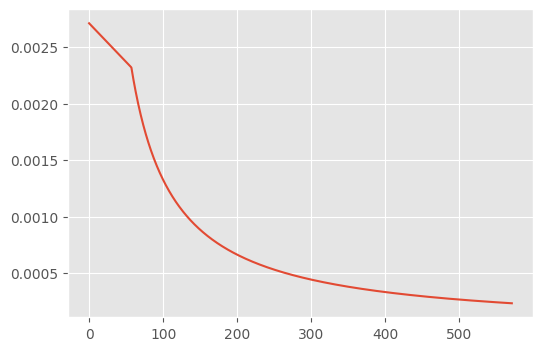

In [24]:
plot_func_fund(604486)

In [25]:
def plot_func_fund_li_nolin(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 3*k_hat, 1000)

    h = 0.01

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]


    alpha_gridl = a_hatl - b_hatl * q_grid

    #plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_gridl)

    
    plt.show()

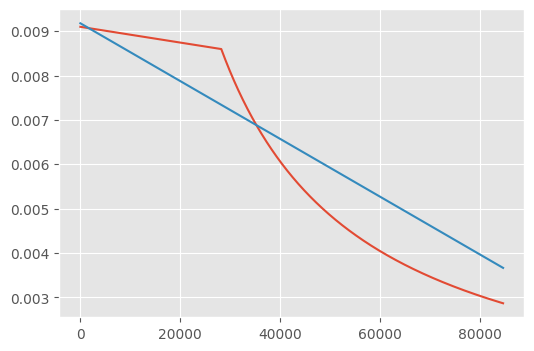

In [102]:
plot_func_fund_li_nolin(101455)

In [27]:
def plot_fit_fund_li_nolin(fundID):

    g = df[df["fund_id"] == fundID].sort_values("time")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    h = 0.01

    y_hat_nl = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) + F.dot(beta_hat).flatten()

    y_hat_lin = (a_hatl - b_hatl * q) + F.dot(beta_hatl).flatten()

    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl, y, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin, y, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Actual Y")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();
    
    plt.show()

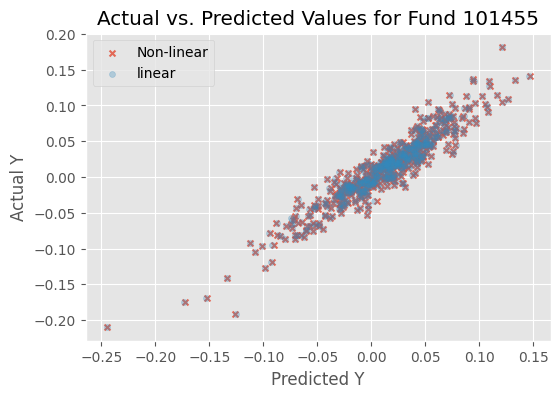

In [103]:
plot_fit_fund_li_nolin(101455)

In [84]:
def plot_fit_fund_li_nolin_subsBeta(fundID):

    g = df[df["fund_id"] == fundID].sort_values("TNA")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    q_grid = np.linspace(0.0001, q.max(), 10000)

    y_subs = y - F.dot(beta_hat).flatten()
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    y_subsl = y - F.dot(beta_hatl).flatten()

    h = 0.01

    y_hat_nl_subs = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) 

    y_hat_lin_subs = (a_hatl - b_hatl * q) 

    plt.figure(figsize=(6,4))
    #plt.scatter(q, y, s=18, alpha= 0.3, marker="x", label= "Y ")
    plt.scatter(q, y_subs, s=18, alpha= 0.3, label= "Y - (betas)")
    
    plt.plot(q,y_hat_nl_subs)
    plt.plot(q,y_hat_lin_subs)
    

    plt.xlabel("size q")
    plt.ylabel("Y - F dot betas")
    plt.title(f"Values for Fund {fundID}")
    plt.legend();
    
    plt.show()



    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl_subs, y_subs, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin_subs, y_subsl, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Y - F dot beta")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();

    
    plt.show()

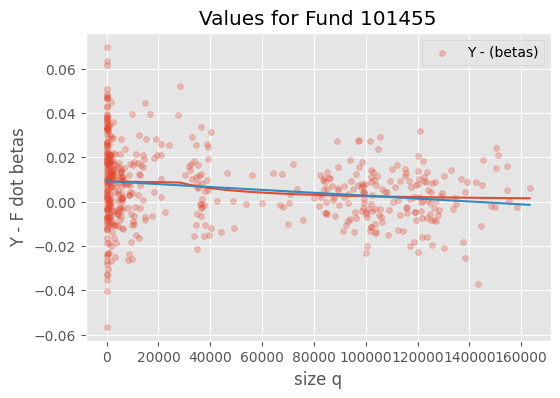

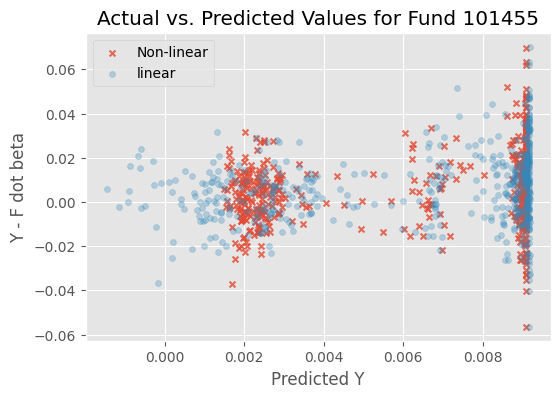

In [104]:
plot_fit_fund_li_nolin_subsBeta(101455)

Excel with results of both specifications

In [34]:
sheet = (estimates_lin[["fund_id", "a_lin", "b_lin"]]
         .merge(estimates[["fund_id", "a", "b", "K"]], on="fund_id")
         .rename(columns={"a":"a_nlin", "b":"b_nl"}))

In [37]:
sheet.to_excel("AllFundsBothSpecifications.xlsx", index=False)

Results for funds with positive a nd b in the linear fit

In [ ]:
est_lin_pos = estimates_lin.query("a_lin >= 0 and b_lin > 0").copy()
#est_nl_pos = estimates.query("a >= 0 and b > 0").copy()

In [40]:
est_nl_pos = estimates[estimates.fund_id.isin(set(est_lin_pos.fund_id))]
est_nl_pos

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052
2,0.003189,-6.335544e-05,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.170981
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992
4,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311
5,-1.206831,-1.746756e-02,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108
2313,0.007503,1.281765e-04,64.532826,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266505
2314,0.006428,-2.159564e-05,46.186083,0.924702,0.281982,-0.272348,-0.051015,0.003590,True,63,0.957530,603044,-148.837497
2316,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392


In [41]:
df_positive = df[df.fund_id.isin(set(est_lin_pos.fund_id))]

In [44]:
df_single_fund = df_positive
df_single_fund["fund_id"] = 1
df_single_fund

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_20828/976209813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_fund["fund_id"] = 1


,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
517584,223,1,1,0.046934,8.809140,0,0,0,0,0,...,0,0,0,0,0,1.0,0.035443,0.005237,-0.005185,0.0258
519905,224,1,1,0.048822,23.466464,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.010269,0.035889,0.007661,0.0341
522226,225,1,1,-0.010571,40.921777,0,0,0,0,0,...,0,0,0,0,0,1.0,0.018486,0.005064,-0.026427,-0.0267
524547,226,1,1,-0.030343,59.166951,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.012031,-0.023049,-0.011480,-0.0471
526868,227,1,1,0.049696,73.954055,0,0,0,0,0,...,0,0,0,0,0,1.0,0.009790,0.022080,0.000757,0.0229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241733,534,2319,1,0.002004,48.114893,0,0,0,0,0,...,0,0,0,0,0,1.0,0.012473,-0.008616,-0.013872,0.0272
1244054,535,2319,1,-0.002624,48.052107,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.017441,-0.033533,-0.021151,0.0766
1246375,536,2319,1,0.030620,47.881574,0,0,0,0,0,...,0,0,0,0,0,1.0,0.016911,0.002096,0.037129,-0.0685
1248696,537,2319,1,0.016188,45.260159,0,0,0,0,0,...,0,0,0,0,0,1.0,0.020159,0.004677,-0.013553,0.0029


In [45]:
estimates_single_fund = estimate_all_funds(df_single_fund)
estimates_single_fund

100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id
0,0.004917,0.000003,782.607997,0.951478,0.373523,-0.040822,0.013204,138.021532,True,436378,0.875037,1


benchmark discounted R2

In [ ]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)








In [58]:
def alpha_lin_gauss(a, b, K, q, h):
    
    return (a - b*q)

In [65]:
for fid in estimates["fund_id"]:
    print(fid)

100001
100003
100004
100006
100009
100010
100016
100017
100018
100019
100022
100030
100033
100036
100040
100046
100047
100048
100055
100068
100071
100072
100075
100076
100079
100085
100087
100089
100090
100092
100093
100096
100097
100098
100099
100101
100111
100113
100127
100150
100153
100159
100160
100166
100167
100171
100190
100196
100207
100209
100217
100222
100223
100226
100228
100237
100244
100245
100247
100250
100259
100275
100278
100280
100286
100287
100290
100291
100292
100293
100298
100299
100303
100305
100313
100315
100319
100320
100322
100323
100324
100330
100333
100336
100343
100344
100350
100351
100352
100355
100358
100360
100362
100365
100368
100379
100389
100395
100398
100399
100401
100408
100409
100411
100415
100419
100424
100430
100431
100441
100451
100453
100457
100460
100463
100468
100475
100485
100514
100521
100531
100535
100538
100543
100548
100561
100564
100567
100574
100590
100598
100600
100610
100611
100614
100622
100624
100625
100633
100634
100637
100639
100642

In [69]:
def add_gross_alpha_R2(estimates_df, method):
    
    r2_values = []

    for fid in estimates_df["fund_id"]:

        g = df[df["fund_id"] == fid].sort_values("TNA")
        q = g["TNA"].to_numpy(float)
        y = g["Y"].to_numpy(float)
        F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)
    
        a = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 0]
        b = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 1]
        k = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 2]

        beta_col = [c for c in estimates_df.columns if c.startswith("beta")]
        beta = estimates_df.loc[estimates_df["fund_id"] == fid, beta_col].to_numpy(float).reshape(-1, 1)

        y_subs = y - F.dot(beta).flatten()

        h = 0.01

        y_hat_subs = method(a, b, k, q, h) 


        # R2 = 1 - (sum of squares of residuals) / (total sum of squares)
        ss_total = np.sum((y_subs - np.mean(y_subs)) ** 2)
        ss_residual = np.sum((y_subs - y_hat_subs) ** 2)

        r_squared = 1 - (ss_residual / ss_total)

        r2_values.append({"fund_id": fid, "r_squared": r_squared})

    r2_df = pd.DataFrame(r2_values)
    
    estimates_df = pd.merge(estimates_df, r2_df, on="fund_id", how="left")

    return estimates_df
    

In [70]:
est_lin_pos_gross_r2 = add_gross_alpha_R2(est_lin_pos, alpha_lin_gauss)

In [71]:
est_lin_pos_gross_r2

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id,r_squared
0,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,100003,0.000577
1,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,100004,0.003646
2,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,100006,0.018171
3,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,100009,0.004509
4,0.005639,2.637993e-06,0.836585,0.057675,0.165395,0.050502,0.790500,0.118724,341,1068.760811,100010,0.004026
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0.010257,4.415307e-04,0.972123,0.838933,0.289786,-0.149562,0.938669,0.008634,63,11.615427,603034,0.013772
1770,0.001456,4.801583e-06,0.965359,0.038410,0.193675,0.028285,0.941999,0.003950,63,151.604108,603041,0.001731
1771,0.001418,7.012831e-07,0.927379,0.285378,-0.279294,-0.046574,0.911322,0.007496,63,1011.269566,603044,0.000077
1772,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,603104,0.016082


In [72]:
est_nl_pos_gross_r2 = add_gross_alpha_R2(est_nl_pos, alpha_smooth_gauss)

In [73]:
est_nl_pos_gross_r2

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052,0.001039
1,0.003189,-6.335544e-05,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.170981,0.027115
2,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992,0.018410
3,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311,0.023388
4,-1.206831,-1.746756e-02,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916,0.187173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108,0.072105
1770,0.007503,1.281765e-04,64.532826,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266505,0.036292
1771,0.006428,-2.159564e-05,46.186083,0.924702,0.281982,-0.272348,-0.051015,0.003590,True,63,0.957530,603044,-148.837497,0.042705
1772,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392,0.017866


In [77]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.022421
R2_gross_nl       0.037529
R2_gross_delta    0.015107
dtype: float64

In [97]:
cmp1 = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp1["K_delta"] = cmp1["K"] - cmp1["K_theory"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp1[["K_delta", "K", "K_theory"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


K_delta     -67.508280
K           698.205905
K_theory    765.714185
dtype: float64

Positive a and b in the non linear specification

In [86]:
est_nl_pos_gross_r2_nonLinearPositive = est_nl_pos_gross_r2.query("a >= 0 and b > 0").copy()
est_nl_pos_gross_r2_nonLinearPositive.shape

(1291, 14)

In [94]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2_nonLinearPositive[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.026101
R2_gross_nl       0.042208
R2_gross_delta    0.016107
dtype: float64

In [99]:
cmp["K_delta"] = cmp["K"] - cmp["K_theory"]
print("delta = nl - theoretical, only for a,b>0 in both specifications")
print(cmp[["K_delta", "K", "K_theory"]].mean())
print(cmp[["K_delta", "K", "K_theory"]].std())

delta = nl - theoretical, only for a,b>0 in both specifications
K_delta     -506.128707
K            848.718429
K_theory    1354.847136
dtype: float64
K_delta     8288.945681
K           2601.764937
K_theory    9412.286040
dtype: float64


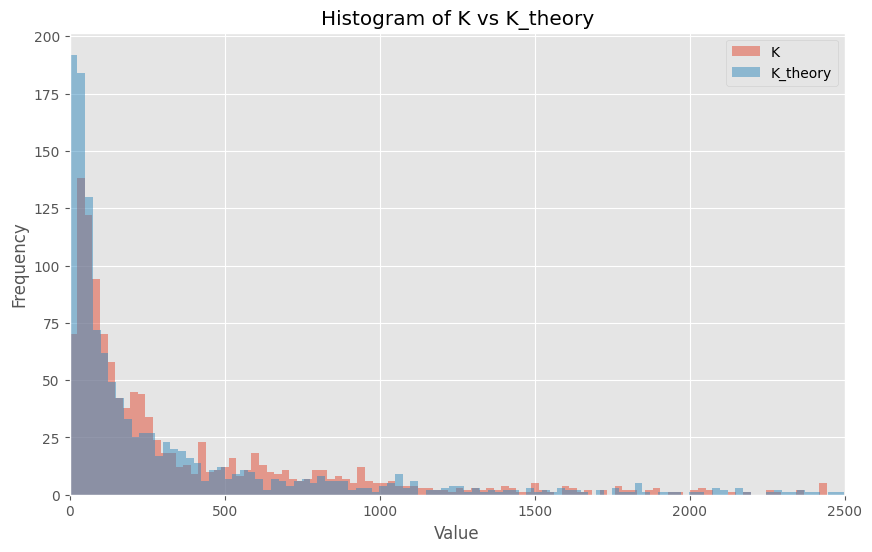

In [116]:
plt.figure(figsize=(10, 6))

filter1 = cmp[cmp['K'] < 2500]
filter2 = cmp[cmp['K_theory'] < 2500]

plt.hist(filter1['K'], bins=100, alpha=0.5, label='K')
plt.hist(filter2['K_theory'], bins=100, alpha=0.5, label='K_theory')

plt.title('Histogram of K vs K_theory')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(0, 2500)
plt.legend()
plt.savefig('k_vs_k_theory_histograms.png')

In [101]:
cmp.loc[cmp['K_theory'].idxmax()]

fund_id           101455.000000
R2_gross_lin           0.040656
K_the_lin          70421.041224
R2_gross_nl            0.042979
K                  28207.084360
K_theory          255821.386569
R2_gross_delta         0.002323
K_delta          -227614.302209
Name: 185, dtype: float64

In [88]:
est_nl_pos_gross_r2_nonLinearPositive

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052,0.001039
2,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992,0.018410
3,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575311,0.023388
5,0.008394,1.148455e-04,36.563410,0.960514,-0.048381,-0.338006,0.106680,0.009384,True,242,0.980909,100016,36.546017,0.026001
7,0.008792,4.646747e-07,3995.196618,0.911846,0.692118,0.055447,0.049566,0.057789,True,539,0.955340,100019,9460.300781,0.026047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,0.006138,7.405474e-06,718.688027,0.852504,0.124212,0.239512,-0.081948,0.005515,True,65,0.922636,602953,414.430944,0.017701
1769,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108,0.072105
1770,0.007503,1.281765e-04,64.532826,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266505,0.036292
1772,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574392,0.017866
